In [1]:
# you will be prompted with a window asking to grant permissions
COLAB = False
if COLAB:
    from google.colab import drive
    drive.mount("/content/drive")

In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
if COLAB:
    work_dir = "/content/drive/My Drive/Your/Assignment3/path/"
else:
    work_dir = "/home/changl25/private/assignment32/"
if not os.path.exists(work_dir) and COLAB:
  !ln -s "/content/drive/My Drive/Your/Assignment3/path/" $work_dir # TODO: Fill your Assignment 3 path
os.chdir(work_dir)
!pwd

/home/changl25/private/assignment32


In [3]:
# In a terminal, Run the `download_data.sh` script in the data folder of assignment 3 part 2
# !. download_data.sh

In [3]:
import os
import random

import cv2
import numpy as np
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import models
from IPython.display import display, clear_output

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv

import matplotlib.pyplot as plt
import collections


import wandb
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
! nvidia-smi

Wed Apr  3 21:37:27 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   28C    P2    59W / 250W |  12187MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN Xp     Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   

In [5]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [ ]:
load_network_path = 'checkpoints/best_detector.pth' 
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

In [9]:
learning_rate = 0.001
num_epochs = 75
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [13]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [14]:
file_root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


## Set up training tools

In [10]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=5e-4)

## Train detector

In [7]:
from torch.cuda.amp import autocast, GradScaler

def train(net, optimizer, criterion, train_loader, epoch):
    total_loss = collections.defaultdict(int)
    net.train()
    
    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % int(len(train_loader) / 3) == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    return total_loss

def train_amp(net, optimizer, criterion, train_loader, epoch):
    scaler = GradScaler()
    total_loss = collections.defaultdict(int)
    net.train()
    
    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        with autocast():
            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            for key in loss_dict:
                total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        scaler.scale(loss_dict['total_loss']).backward()
        scaler.step(optimizer)
        scaler.update()
    
        if (i+1) % int(len(train_loader) / 3) == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    return total_loss

In [8]:
# select random image from test set
def evaluate_img(net, dataset):
    image_name = random.choice(dataset.fnames)
    image = cv2.imread(os.path.join(file_root_test, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    print('predicting...')
    result = predict_image(net, image_name, root_img_directory=file_root_test)
    for left_up, right_bottom, class_name, _, prob in result:
        color = COLORS[VOC_CLASSES.index(class_name)]
        cv2.rectangle(image, left_up, right_bottom, color, 2)
        label = class_name + str(round(prob, 2))
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1] - text_size[1])
        cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                    color, -1)
        cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)
    return image



In [9]:
def init_wandb(optimizer, lr, num_epochs, batch_size, net):
    wandb.init(
        project="yolov2",
        config={   
            "optimizer": optimizer,
            "learning_rate": lr,
            "batch_size": batch_size,
            "num_epochs": num_epochs,   
                })
    wandb.watch(net)

In [15]:
best_test_loss = np.inf
learning_rate = 1e-3
use_wandb = True 

if use_wandb:
    init_wandb(optimizer, learning_rate, num_epochs, batch_size, net)
    
for epoch in range(num_epochs):
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    train_loss = train(net, optimizer, criterion, train_loader, num_epochs)
    # train_loss = train_amp(net, optimizer, criterion, train_loader, num_epochs)
    
    with torch.no_grad():
        test_loss = 0.0
        test_loss = collections.defaultdict(int)
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data
            
            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            for key in loss_dict:
                test_loss[key] += loss_dict[key].item() / len(test_loader)
    
    if best_test_loss > test_loss['total_loss']:
        best_test_loss = test_loss['total_loss']
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')
        # test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test, test_loader=test_loader, batch_num=2)
        # print(epoch, test_aps)
        
        if use_wandb:
            best_image = evaluate_img(net, test_dataset)
            wandb.log({"eval_images": wandb.Image(best_image)})
        # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
        
    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')
    
    if use_wandb:
        for key in test_loss:
            wandb.log({f"train {key}": train_loss[key] / len(train_loader)}, step = epoch + 1)
            wandb.log({f"test {key}": test_loss[key]}, step = epoch + 1)
if use_wandb:    
    wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ruachang (changln). Use `wandb login --relogin` to force relogin




Starting epoch 1 / 75
Learning Rate for this epoch: 0.001
Epoch [1/75], Iter [69/209], Loss: total=19.026, reg=3.191, containing_obj=0.376, no_obj=9.214, cls=6.246
Epoch [1/75], Iter [138/209], Loss: total=12.751, reg=2.804, containing_obj=0.496, no_obj=4.791, cls=4.660
Epoch [1/75], Iter [207/209], Loss: total=10.350, reg=2.605, containing_obj=0.561, no_obj=3.280, cls=3.904
Updating best test loss: 5.37453
predicting...


Starting epoch 2 / 75
Learning Rate for this epoch: 0.001
Epoch [2/75], Iter [69/209], Loss: total=5.046, reg=2.089, containing_obj=0.745, no_obj=0.199, cls=2.013
Epoch [2/75], Iter [138/209], Loss: total=4.938, reg=2.053, containing_obj=0.761, no_obj=0.182, cls=1.942
Epoch [2/75], Iter [207/209], Loss: total=4.829, reg=2.022, containing_obj=0.773, no_obj=0.168, cls=1.865
Updating best test loss: 4.56393
predicting...


Starting epoch 3 / 75
Learning Rate for this epoch: 0.001
Epoch [3/75], Iter [69/209], Loss: total=4.493, reg=1.964, containing_obj=0.846, no_obj=0

100%|████████████████████████████████████████████| 4950/4950 [02:20<00:00, 35.12it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0---
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.0--- (no predictions for this class)
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0---
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0--- (no predictions for this class)
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
--

100%|████████████████████████████████████████████| 4950/4950 [02:18<00:00, 35.75it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0---
---class bus ap 0.0---
---class car ap 0.0--- (no predictions for this class)
---class cat ap 0.0---
---class chair ap 0.0---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0--- (no predictions for this class)
---class pottedplant ap 0.0---
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0---
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.0--- (no predictions for this class)
---map 0.0---
9 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:34<00:00, 32.07it/s]


---class aeroplane ap 0.43101076111999087---
---class bicycle ap 0.48465336574135154---
---class bird ap 0.30750380677048295---
---class boat ap 0.15818132908728108---
---class bottle ap 0.09299882552746319---
---class bus ap 0.36455871981065263---
---class car ap 0.507625725193209---
---class cat ap 0.5882212161378386---
---class chair ap 0.2335486121391548---
---class cow ap 0.3719877600838077---
---class diningtable ap 0.08520373643210283---
---class dog ap 0.44878317704785764---
---class horse ap 0.5888237333637659---
---class motorbike ap 0.33601502579311626---
---class person ap 0.3527865648149815---
---class pottedplant ap 0.10002868247526182---
---class sheep ap 0.3203770972590633---
---class sofa ap 0.29299127765588057---
---class train ap 0.3868661887507603---
---class tvmonitor ap 0.39429547061985315---
---map 0.34232305379119377---
14 [0.43101076111999087, 0.48465336574135154, 0.30750380677048295, 0.15818132908728108, 0.09299882552746319, 0.36455871981065263, 0.507625725193

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:34<00:00, 32.10it/s]


---class aeroplane ap 0.39801800955646516---
---class bicycle ap 0.5048495072278363---
---class bird ap 0.4097195296444184---
---class boat ap 0.22731854918346833---
---class bottle ap 0.0985247323245553---
---class bus ap 0.5534212859929024---
---class car ap 0.5981495829114661---
---class cat ap 0.6029662739209191---
---class chair ap 0.19821445185335987---
---class cow ap 0.4455584565412008---
---class diningtable ap 0.18108931186685745---
---class dog ap 0.4953844983022137---
---class horse ap 0.6268349330367498---
---class motorbike ap 0.496072180726187---
---class person ap 0.4256143119067104---
---class pottedplant ap 0.15843023277784868---
---class sheep ap 0.420434582001821---
---class sofa ap 0.38532875677343786---
---class train ap 0.5403380651128984---
---class tvmonitor ap 0.3916709379138794---
---map 0.4078969094787598---
19 [0.39801800955646516, 0.5048495072278363, 0.4097195296444184, 0.22731854918346833, 0.0985247323245553, 0.5534212859929024, 0.5981495829114661, 0.6029

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:26<00:00, 33.70it/s]


---class aeroplane ap 0.5629504630103908---
---class bicycle ap 0.5739971861643836---
---class bird ap 0.4672119846773018---
---class boat ap 0.23843777899666485---
---class bottle ap 0.11129427138585807---
---class bus ap 0.5999545364098127---
---class car ap 0.6243088380579624---
---class cat ap 0.660078103050094---
---class chair ap 0.22773111607867935---
---class cow ap 0.45421833859649346---
---class diningtable ap 0.34764673316285133---
---class dog ap 0.5092559639534211---
---class horse ap 0.6355990824276345---
---class motorbike ap 0.4950589837210355---
---class person ap 0.4794748519325321---
---class pottedplant ap 0.2116858745489108---
---class sheep ap 0.3709764571832546---
---class sofa ap 0.45103311860997963---
---class train ap 0.5967743392182128---
---class tvmonitor ap 0.416583698377748---
---map 0.451713585978161---
24 [0.5629504630103908, 0.5739971861643836, 0.4672119846773018, 0.23843777899666485, 0.11129427138585807, 0.5999545364098127, 0.6243088380579624, 0.66007

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:33<00:00, 32.22it/s]


---class aeroplane ap 0.5432646174356639---
---class bicycle ap 0.6148239288998043---
---class bird ap 0.49788933749667835---
---class boat ap 0.2442139616543736---
---class bottle ap 0.17484978471577337---
---class bus ap 0.6199055045695088---
---class car ap 0.6600260130675588---
---class cat ap 0.671844316571863---
---class chair ap 0.28879219500135617---
---class cow ap 0.4906217938331061---
---class diningtable ap 0.22431949268555748---
---class dog ap 0.6108402040386582---
---class horse ap 0.6660105864900441---
---class motorbike ap 0.5112519953266685---
---class person ap 0.5069898413133117---
---class pottedplant ap 0.18000486256686338---
---class sheep ap 0.43295615223959183---
---class sofa ap 0.4623737020781339---
---class train ap 0.6006163467705804---
---class tvmonitor ap 0.422924835790035---
---map 0.4712259736272565---
29 [0.5432646174356639, 0.6148239288998043, 0.49788933749667835, 0.2442139616543736, 0.17484978471577337, 0.6199055045695088, 0.6600260130675588, 0.6718

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:29<00:00, 33.15it/s]


---class aeroplane ap 0.531382057500141---
---class bicycle ap 0.6060249232198557---
---class bird ap 0.5158984917981908---
---class boat ap 0.3139877411226224---
---class bottle ap 0.20589386752658315---
---class bus ap 0.6488316064596611---
---class car ap 0.6701042492707235---
---class cat ap 0.704353150337587---
---class chair ap 0.27109020784198967---
---class cow ap 0.5180109434701937---
---class diningtable ap 0.3797759238509585---
---class dog ap 0.589534190320913---
---class horse ap 0.670346812095381---
---class motorbike ap 0.5518200530664814---
---class person ap 0.5305516595728444---
---class pottedplant ap 0.23678332790646073---
---class sheep ap 0.48682903906732145---
---class sofa ap 0.4908655730399229---
---class train ap 0.6162684728002552---
---class tvmonitor ap 0.4199917638529995---
---map 0.49791720270605433---
34 [0.531382057500141, 0.6060249232198557, 0.5158984917981908, 0.3139877411226224, 0.20589386752658315, 0.6488316064596611, 0.6701042492707235, 0.704353150

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:26<00:00, 33.70it/s]


---class aeroplane ap 0.5442494960389379---
---class bicycle ap 0.6123721607325389---
---class bird ap 0.503945293645236---
---class boat ap 0.3032247940541373---
---class bottle ap 0.20853669576035305---
---class bus ap 0.6583162191080686---
---class car ap 0.6637202183341395---
---class cat ap 0.7050346685286621---
---class chair ap 0.27171620756003984---
---class cow ap 0.5305436877732097---
---class diningtable ap 0.3563973861208642---
---class dog ap 0.6106609900067197---
---class horse ap 0.6806211991008138---
---class motorbike ap 0.5680943969718624---
---class person ap 0.5278946296388798---
---class pottedplant ap 0.2258377923052696---
---class sheep ap 0.47608031741259244---
---class sofa ap 0.5067927244770649---
---class train ap 0.6395644897090842---
---class tvmonitor ap 0.4200207991732775---
---map 0.5006812083225876---
39 [0.5442494960389379, 0.6123721607325389, 0.503945293645236, 0.3032247940541373, 0.20853669576035305, 0.6583162191080686, 0.6637202183341395, 0.70503466

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:24<00:00, 34.22it/s]


---class aeroplane ap 0.5196181921418211---
---class bicycle ap 0.6267212278504288---
---class bird ap 0.5424244961909317---
---class boat ap 0.2922878625826328---
---class bottle ap 0.2051062601345758---
---class bus ap 0.6727788679720206---
---class car ap 0.6752895266447025---
---class cat ap 0.7140943474494661---
---class chair ap 0.28862030435607994---
---class cow ap 0.5400799626432219---
---class diningtable ap 0.3523199324930314---
---class dog ap 0.6402740167095234---
---class horse ap 0.6885452844545064---
---class motorbike ap 0.5813431261280944---
---class person ap 0.5391785338150006---
---class pottedplant ap 0.22075551497228374---
---class sheep ap 0.4482533924741628---
---class sofa ap 0.4842986486258269---
---class train ap 0.62761191830354---
---class tvmonitor ap 0.44190987691335426---
---map 0.5050755646427604---
44 [0.5196181921418211, 0.6267212278504288, 0.5424244961909317, 0.2922878625826328, 0.2051062601345758, 0.6727788679720206, 0.6752895266447025, 0.714094347

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:36<00:00, 31.66it/s]


---class aeroplane ap 0.5283629601921707---
---class bicycle ap 0.591992775001585---
---class bird ap 0.46621237993977316---
---class boat ap 0.32306135349141285---
---class bottle ap 0.20645134475696986---
---class bus ap 0.6456625148327462---
---class car ap 0.662739834071286---
---class cat ap 0.6932276327712609---
---class chair ap 0.25165434640922735---
---class cow ap 0.4952847023515053---
---class diningtable ap 0.3688853544890375---
---class dog ap 0.5895867132661834---
---class horse ap 0.6692436089853515---
---class motorbike ap 0.5555681119720399---
---class person ap 0.523523867249225---
---class pottedplant ap 0.21030731599392768---
---class sheep ap 0.48817980950027906---
---class sofa ap 0.5039950228485877---
---class train ap 0.6170603393770913---
---class tvmonitor ap 0.3979132768106747---
---map 0.4894456632155168---
49 [0.5283629601921707, 0.591992775001585, 0.46621237993977316, 0.32306135349141285, 0.20645134475696986, 0.6456625148327462, 0.662739834071286, 0.693227

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:26<00:00, 33.69it/s]


---class aeroplane ap 0.5286069475682402---
---class bicycle ap 0.6215219020665954---
---class bird ap 0.5170661623928345---
---class boat ap 0.3202496833014388---
---class bottle ap 0.21185757794788118---
---class bus ap 0.6656656675554146---
---class car ap 0.6740385814801383---
---class cat ap 0.7079249201251738---
---class chair ap 0.2698062423739507---
---class cow ap 0.5418907721715467---
---class diningtable ap 0.37008702630268064---
---class dog ap 0.602953195457791---
---class horse ap 0.6790227565101701---
---class motorbike ap 0.5516347279888385---
---class person ap 0.5332161900409387---
---class pottedplant ap 0.22968117252556652---
---class sheep ap 0.48787349993526846---
---class sofa ap 0.49567272166334553---
---class train ap 0.6506718415250035---
---class tvmonitor ap 0.4278502342561308---
---map 0.5043645911594473---
54 [0.5286069475682402, 0.6215219020665954, 0.5170661623928345, 0.3202496833014388, 0.21185757794788118, 0.6656656675554146, 0.6740385814801383, 0.70792

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:28<00:00, 33.35it/s]


---class aeroplane ap 0.5159120342293413---
---class bicycle ap 0.6129418329101983---
---class bird ap 0.5315207444107755---
---class boat ap 0.3141121846422753---
---class bottle ap 0.2169278470258102---
---class bus ap 0.6562212480075726---
---class car ap 0.6666050452827845---
---class cat ap 0.7059855066025507---
---class chair ap 0.28374104575267667---
---class cow ap 0.5137205667564166---
---class diningtable ap 0.3788981988141122---
---class dog ap 0.6090785620197954---
---class horse ap 0.6705885054869201---
---class motorbike ap 0.5735559611238911---
---class person ap 0.5342344770492462---
---class pottedplant ap 0.22317353594724007---
---class sheep ap 0.4754517151168747---
---class sofa ap 0.5057278710156698---
---class train ap 0.6382288327921479---
---class tvmonitor ap 0.45169049778585424---
---map 0.5039158106386077---
59 [0.5159120342293413, 0.6129418329101983, 0.5315207444107755, 0.3141121846422753, 0.2169278470258102, 0.6562212480075726, 0.6666050452827845, 0.7059855

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:21<00:00, 35.01it/s]


---class aeroplane ap 0.5405930590413346---
---class bicycle ap 0.6139281965843537---
---class bird ap 0.5091379292639188---
---class boat ap 0.3314041730291357---
---class bottle ap 0.20815336343094662---
---class bus ap 0.6640084401893912---
---class car ap 0.6694501580615461---
---class cat ap 0.7088890582783869---
---class chair ap 0.2543839614679953---
---class cow ap 0.5064473112912248---
---class diningtable ap 0.36589887176387353---
---class dog ap 0.6106485304809482---
---class horse ap 0.6897018136937743---
---class motorbike ap 0.5638673365470492---
---class person ap 0.5330608439724642---
---class pottedplant ap 0.22868618891338965---
---class sheep ap 0.4708998615863794---
---class sofa ap 0.502689258440616---
---class train ap 0.6337774838928093---
---class tvmonitor ap 0.42542094519306606---
---map 0.5015523392561302---
64 [0.5405930590413346, 0.6139281965843537, 0.5091379292639188, 0.3314041730291357, 0.20815336343094662, 0.6640084401893912, 0.6694501580615461, 0.708889

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:29<00:00, 33.04it/s]


---class aeroplane ap 0.5285888077669629---
---class bicycle ap 0.6170414531427311---
---class bird ap 0.533853333604705---
---class boat ap 0.3090574925513604---
---class bottle ap 0.20858312196248732---
---class bus ap 0.6620377417027068---
---class car ap 0.6830217633530964---
---class cat ap 0.7167422643031477---
---class chair ap 0.26792582878600574---
---class cow ap 0.5340922075737573---
---class diningtable ap 0.39088656855534143---
---class dog ap 0.6176012547481116---
---class horse ap 0.6765038124800716---
---class motorbike ap 0.5870336717969014---
---class person ap 0.5397296775339968---
---class pottedplant ap 0.24131259336332392---
---class sheep ap 0.4761115198407244---
---class sofa ap 0.4993296712587294---
---class train ap 0.634796313791569---
---class tvmonitor ap 0.42636403436515957---
---map 0.5075306566240444---
69 [0.5285888077669629, 0.6170414531427311, 0.533853333604705, 0.3090574925513604, 0.20858312196248732, 0.6620377417027068, 0.6830217633530964, 0.7167422

100%|█████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:32<00:00, 32.55it/s]


---class aeroplane ap 0.544300746715152---
---class bicycle ap 0.6180654015336873---
---class bird ap 0.5100936443196294---
---class boat ap 0.32360727373747633---
---class bottle ap 0.2138180999461074---
---class bus ap 0.6434000772290639---
---class car ap 0.6687711116369239---
---class cat ap 0.7067746104091026---
---class chair ap 0.2721307514458551---
---class cow ap 0.5058521416444389---
---class diningtable ap 0.36710375690611247---
---class dog ap 0.6017977308883274---
---class horse ap 0.6792947139626386---
---class motorbike ap 0.5714817208608691---
---class person ap 0.5351976922553354---
---class pottedplant ap 0.23181590606996147---
---class sheep ap 0.48091367815011016---
---class sofa ap 0.5049125296824695---
---class train ap 0.633890963411551---
---class tvmonitor ap 0.4371879679337058---
---map 0.5025205259369259---
74 [0.544300746715152, 0.6180654015336873, 0.5100936443196294, 0.32360727373747633, 0.2138180999461074, 0.6434000772290639, 0.6687711116369239, 0.70677461

test cls_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test containing_obj_loss,▁▄▆▇██▄▃▃▂▂▄▂▃▃▃▂▃▃▃▄▄▃▄▄▃▄▃▄▄▄▄▃▄▄▃▄▃▄▄
test no_obj_loss,█▄▂▁▁▁▄▅▅▆▅▅▆▆▅▆▆▆▆▅▅▆▆▆▅▆▅▆▅▆▅▆▆▅▅▆▅▆▅▅
test reg_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test total_loss,█▆▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train cls_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train containing_obj_loss,▁▄▆▇██▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
train no_obj_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train reg_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train total_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test cls_loss,0.45638


In [13]:
evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:22<00:00, 34.75it/s]


---class aeroplane ap 0.5196181921418211---
---class bicycle ap 0.6267212278504288---
---class bird ap 0.5424244961909317---
---class boat ap 0.2922878625826328---
---class bottle ap 0.2051062601345758---
---class bus ap 0.6727788679720206---
---class car ap 0.6752895266447025---
---class cat ap 0.7140943474494661---
---class chair ap 0.28862030435607994---
---class cow ap 0.5400799626432219---
---class diningtable ap 0.3523199324930314---
---class dog ap 0.6402740167095234---
---class horse ap 0.6885452844545064---
---class motorbike ap 0.5813431261280944---
---class person ap 0.5391785338150006---
---class pottedplant ap 0.22075551497228374---
---class sheep ap 0.4482533924741628---
---class sofa ap 0.4842986486258269---
---class train ap 0.62761191830354---
---class tvmonitor ap 0.44190987691335426---
---map 0.5050755646427604---


[0.5196181921418211,
 0.6267212278504288,
 0.5424244961909317,
 0.2922878625826328,
 0.2051062601345758,
 0.6727788679720206,
 0.6752895266447025,
 0.7140943474494661,
 0.28862030435607994,
 0.5400799626432219,
 0.3523199324930314,
 0.6402740167095234,
 0.6885452844545064,
 0.5813431261280944,
 0.5391785338150006,
 0.22075551497228374,
 0.4482533924741628,
 0.4842986486258269,
 0.62761191830354,
 0.44190987691335426]

# View example predictions

predicting...


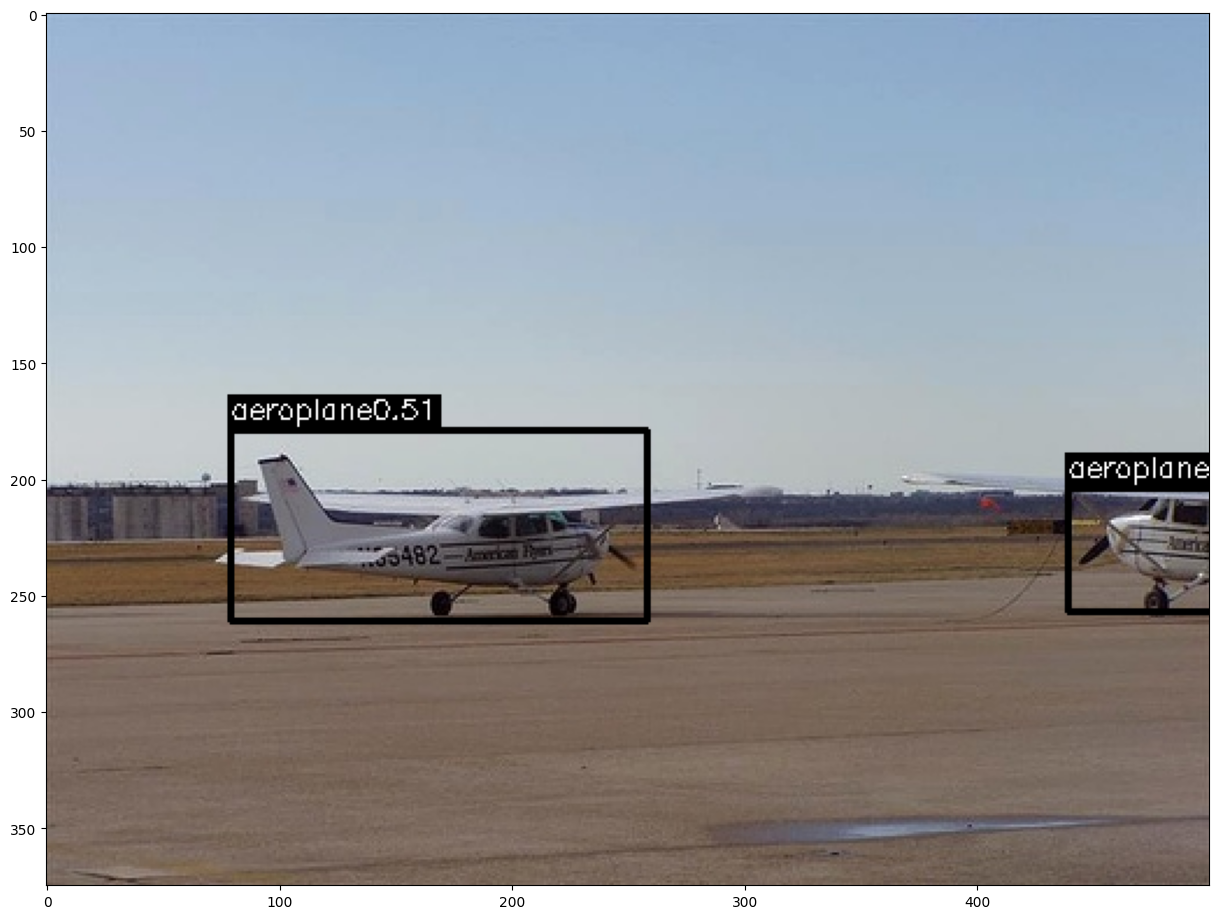

In [16]:
net.eval()

image = evaluate_img(net, test_dataset)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [17]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:25<00:00, 34.05it/s]


---class aeroplane ap 0.5196181921418211---
---class bicycle ap 0.6267212278504288---
---class bird ap 0.5424244961909317---
---class boat ap 0.2922878625826328---
---class bottle ap 0.2051062601345758---
---class bus ap 0.6727788679720206---
---class car ap 0.6752895266447025---
---class cat ap 0.7140943474494661---
---class chair ap 0.28862030435607994---
---class cow ap 0.5400799626432219---
---class diningtable ap 0.3523199324930314---
---class dog ap 0.6402740167095234---
---class horse ap 0.6885452844545064---
---class motorbike ap 0.5813431261280944---
---class person ap 0.5391785338150006---
---class pottedplant ap 0.22075551497228374---
---class sheep ap 0.4482533924741628---
---class sofa ap 0.4842986486258269---
---class train ap 0.62761191830354---
---class tvmonitor ap 0.44190987691335426---
---map 0.5050755646427604---


### Cell added to get intermediate mAP values for students

In [18]:
network_paths = ['./checkpoints/detector_epoch_%d.pth' % epoch for epoch in [5, 10, 20, 30, 40]]+['./checkpoints/detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test, img_root=file_root_test)


Loading saved network from ./checkpoints/detector_epoch_5.pth
---Evaluate model on test samples---


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:14<00:00, 36.77it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0---
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.0--- (no predictions for this class)
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0---
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0--- (no predictions for this class)
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
--

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:10<00:00, 37.90it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0---
---class bus ap 0.0---
---class car ap 0.0--- (no predictions for this class)
---class cat ap 0.0---
---class chair ap 0.0---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0--- (no predictions for this class)
---class pottedplant ap 0.0---
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0---
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.0--- (no predictions for this class)
---map 0.0---
Loading saved network from ./checkpoints/detector_epoch

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:20<00:00, 35.33it/s]


---class aeroplane ap 0.39801800955646516---
---class bicycle ap 0.5048495072278363---
---class bird ap 0.4097195296444184---
---class boat ap 0.22731854918346833---
---class bottle ap 0.0985247323245553---
---class bus ap 0.5534212859929024---
---class car ap 0.5981495829114661---
---class cat ap 0.6029662739209191---
---class chair ap 0.19821445185335987---
---class cow ap 0.4455584565412008---
---class diningtable ap 0.18108931186685745---
---class dog ap 0.4953844983022137---
---class horse ap 0.6268349330367498---
---class motorbike ap 0.496072180726187---
---class person ap 0.4256143119067104---
---class pottedplant ap 0.15843023277784868---
---class sheep ap 0.420434582001821---
---class sofa ap 0.38532875677343786---
---class train ap 0.5403380651128984---
---class tvmonitor ap 0.3916709379138794---
---map 0.4078969094787598---
Loading saved network from ./checkpoints/detector_epoch_30.pth
---Evaluate model on test samples---


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:21<00:00, 35.07it/s]


---class aeroplane ap 0.5432646174356639---
---class bicycle ap 0.6148239288998043---
---class bird ap 0.49788933749667835---
---class boat ap 0.2442139616543736---
---class bottle ap 0.17484978471577337---
---class bus ap 0.6199055045695088---
---class car ap 0.6600260130675588---
---class cat ap 0.671844316571863---
---class chair ap 0.28879219500135617---
---class cow ap 0.4906217938331061---
---class diningtable ap 0.22431949268555748---
---class dog ap 0.6108402040386582---
---class horse ap 0.6660105864900441---
---class motorbike ap 0.5112519953266685---
---class person ap 0.5069898413133117---
---class pottedplant ap 0.18000486256686338---
---class sheep ap 0.43295615223959183---
---class sofa ap 0.4623737020781339---
---class train ap 0.6006163467705804---
---class tvmonitor ap 0.422924835790035---
---map 0.4712259736272565---
Loading saved network from ./checkpoints/detector_epoch_40.pth
---Evaluate model on test samples---


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:19<00:00, 35.50it/s]


---class aeroplane ap 0.5442494960389379---
---class bicycle ap 0.6123721607325389---
---class bird ap 0.503945293645236---
---class boat ap 0.3032247940541373---
---class bottle ap 0.20853669576035305---
---class bus ap 0.6583162191080686---
---class car ap 0.6637202183341395---
---class cat ap 0.7050346685286621---
---class chair ap 0.27171620756003984---
---class cow ap 0.5305436877732097---
---class diningtable ap 0.3563973861208642---
---class dog ap 0.6106609900067197---
---class horse ap 0.6806211991008138---
---class motorbike ap 0.5680943969718624---
---class person ap 0.5278946296388798---
---class pottedplant ap 0.2258377923052696---
---class sheep ap 0.47608031741259244---
---class sofa ap 0.5067927244770649---
---class train ap 0.6395644897090842---
---class tvmonitor ap 0.4200207991732775---
---map 0.5006812083225876---
Loading saved network from ./checkpoints/detector.pth
---Evaluate model on test samples---


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:23<00:00, 34.41it/s]


---class aeroplane ap 0.544300746715152---
---class bicycle ap 0.6180654015336873---
---class bird ap 0.5100936443196294---
---class boat ap 0.32360727373747633---
---class bottle ap 0.2138180999461074---
---class bus ap 0.6434000772290639---
---class car ap 0.6687711116369239---
---class cat ap 0.7067746104091026---
---class chair ap 0.2721307514458551---
---class cow ap 0.5058521416444389---
---class diningtable ap 0.36710375690611247---
---class dog ap 0.6017977308883274---
---class horse ap 0.6792947139626386---
---class motorbike ap 0.5714817208608691---
---class person ap 0.5351976922553354---
---class pottedplant ap 0.23181590606996147---
---class sheep ap 0.48091367815011016---
---class sofa ap 0.5049125296824695---
---class train ap 0.633890963411551---
---class tvmonitor ap 0.4371879679337058---
---map 0.5025205259369259---


In [19]:
output_submission_csv('my_new_solution.csv', test_aps)

## Extra credit

In [14]:
from src.config import VOC_CLASSES, VOC_IMG_MEAN, YOLO_IMG_DIM
import torchvision.transforms as transforms
from torch.autograd import Variable
from src.predict import decoder

def detect_video(net, video_path, output_path, resolution):
    net.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    cap = cv2.VideoCapture(video_path)

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_path, fourcc, 24, resolution)

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            with torch.no_grad():
                result = []
                h, w, _ = frame.shape
                # print(h, w)
                frame = cv2.resize(frame, resolution)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = cv2.resize(frame, (YOLO_IMG_DIM, YOLO_IMG_DIM))
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mean = VOC_IMG_MEAN
                img = img - np.array(mean, dtype=np.float32)

                transform = transforms.Compose(
                    [
                        transforms.ToTensor(),
                    ]
                )
                img = transform(img)
                img = Variable(img[None, :, :, :])
                img = img.cuda()

                pred = net(img)  # 1xSxSx(B*5+C)
                pred = pred.cpu()
                boxes, cls_indexs, probs = decoder(pred)

                for i, box in enumerate(boxes):
                    x1 = int(box[0] * w)
                    x2 = int(box[2] * w)
                    y1 = int(box[1] * h)
                    y2 = int(box[3] * h)
                    cls_index = cls_indexs[i]
                    cls_index = int(cls_index)  # convert LongTensor to int
                    prob = probs[i]
                    prob = float(prob)
                    result.append(
                        [(x1, y1), (x2, y2), VOC_CLASSES[cls_index], prob]
                    )
                for left_up, right_bottom, class_name, prob in result:
                    color = COLORS[VOC_CLASSES.index(class_name)]
                    cv2.rectangle(frame, left_up, right_bottom, color, 2)
                    label = class_name + str(round(prob, 2))
                    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
                    p1 = (left_up[0], left_up[1] - text_size[1])
                    cv2.rectangle(frame, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                                color, -1)
                    cv2.putText(frame, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

            # Write the frame with detections to the new video
            out.write(frame)
        else:
            break

    # Release everything when job is finished
    cap.release()
    out.release()

def display_video(video_path):
    cap = cv2.VideoCapture(video_path)

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            with torch.no_grad():
                h, w, _ = frame.shape
                # print(h, w)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(frame)
                display(img)
                # Clear the output after each frame to display the next frame in the same cell
                clear_output(wait=True)
        else:
            break

    # Release everything when job is finished
    cap.release()

In [61]:
detect_video(net, "data/detect_walker_cut.mp4", "data/detected_walker_copy.mp4",(852, 480))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


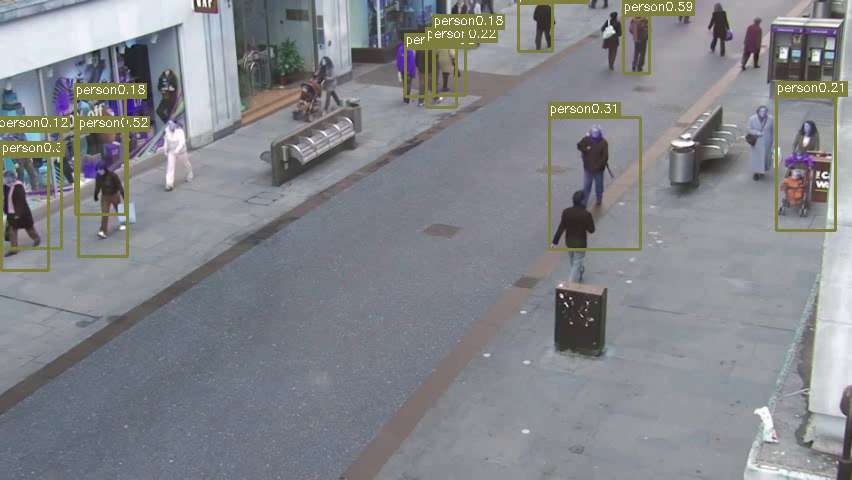

In [15]:
display_video("/home/changl25/private/assignment32/data/detected_walker_copy.mp4")

In [10]:
S = 7
B = 2

In [22]:
from src.darknet import darknet53
# model_path = "cp/detector_epoch_5.pth"
model = darknet53(S, B, len(VOC_CLASSES), pretrained=None)
# model = darknet53(S, B, len(VOC_CLASSES), pretrained=model_path)
model = model.to(device)

In [12]:

learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5


In [20]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

file_root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 5011 train images
Initializing dataset
Loaded 4950 test images


In [15]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

In [ ]:
images, target_boxes, target_cls, has_object_map = next(iter(test_loader))
res = model(images[0].unsqueeze(0).to(device))
print(target_cls.shape, res.shape)
# res

In [ ]:
best_test_loss = np.inf
use_wandb = True 

if use_wandb:
    init_wandb(optimizer, learning_rate, num_epochs, batch_size, model)
    
for epoch in range(num_epochs):
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    train_loss = train(model, optimizer, criterion, train_loader, epoch)
    # train_loss = train_amp(net, optimizer, criterion, train_loader, num_epochs)
    
    with torch.no_grad():
        test_loss = 0.0
        test_loss = collections.defaultdict(int)
        model.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data
            pred = model(images)
            
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            for key in loss_dict:
                test_loss[key] += loss_dict[key].item() / len(test_loader)
    
    if best_test_loss > test_loss['total_loss']:
        best_test_loss = test_loss['total_loss']
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(model.state_dict(),'checkpoints/best_detector.pth')
        # test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test, test_loader=test_loader, batch_num=2)
        # print(epoch, test_aps)
        
        if use_wandb:
            best_image = evaluate_img(model, test_dataset)
            wandb.log({"eval_images": wandb.Image(best_image)})
        # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(model, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
        
    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(model.state_dict(),'cp/detector_epoch_%d.pth' % (epoch+6))

    torch.save(model.state_dict(),'cp/detector.pth')
    
    if use_wandb:
        for key in test_loss:
            wandb.log({f"train {key}": train_loss[key] / len(train_loader)}, step = epoch + 1)
            wandb.log({f"test {key}": test_loss[key]}, step = epoch + 1)
if use_wandb:    
    wandb.finish()

In [ ]:
from torchsummary import summary
summary(net, (3, 448, 448))

from torchsummary import summary
summary(model, (3, 448, 448))